In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from src.functions.basic_functions import coordinates_change,globus
from src.functions.grid import land_reference_subunit,construct_grid, estimate_kernel_density_database
from src.functions.weights import weigths_continent, weighted_plants_dataset
from src.functions.plots import unweighted_plot_density, choose_bandwidth,weighted_plants_plot_density,weighted_plot_density, plot_density_combination

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.basemap import Basemap
import global_land_mask,tqdm, itertools
from global_land_mask import globe
import sklearn
sklearn.set_config(enable_metadata_routing=True)
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV


In [4]:
df_gspt=pd.read_csv("data\clean_data\steel_factories_dataset.csv")

Cross-Validation Bandwiths

In [ ]:
choose_bandwidth('Europe','exponential') # 0.041363636363636366
choose_bandwidth('Europe','gaussian') #0.08172727272727273

Maps

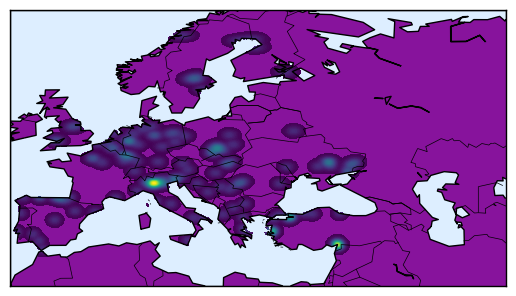

In [182]:
unweighted_plot_density('Europe','gaussian',0.007)

In [ ]:
weighted_plants_plot_density('Europe', 'exponential', 0.007)

In [9]:
weighted_plot_density('North America', 'exponential', 0.007)

In [ ]:
unweighted_plot_density('world','exponential',0.007)

Mix LitPop & Kernel Maps

In [6]:
world=pd.read_csv("data\intermediary_data\densities\world_all_densities.csv")

In [ ]:
plot_density_combination(world,0)

In [ ]:
plot_density_combination(world,0.5)

In [ ]:
plot_density_combination(world,0)